## ESTIMACIÓN DE CURVAS DE KAPLAN-MEIER

En este notebook se realiza un análisis de supervivencia utilizando el método no paramétrico de Kaplan-Meier, aplicado a un conjunto de datos clínicos de pacientes con distintos tipos de cáncer. El objetivo es estimar la probabilidad de supervivencia a lo largo del tiempo y comparar la evolución entre grupos definidos por variables clínicas como el tipo de cáncer, género o grupo étnico.

A lo largo del notebook se incluyen:

- Gráficas de curvas de supervivencia con intervalos de confianza para diferentes subgrupos.

- Tablas de frecuencias que muestran la proporción de eventos (fallecimientos) y censuras.

- Comparación visual de curvas mediante histogramas y boxplots.

- Finalmente, se aplica el test de log-rank para evaluar si existen diferencias estadísticamente significativas entre las curvas de supervivencia de los distintos grupos analizados.

Este análisis permite identificar patrones de supervivencia en función de características clínicas, lo que puede contribuir a mejorar la estratificación del riesgo y la toma de decisiones en el ámbito médico.

In [24]:
# Celda de ejecución de posibles librerias a instalar
#pip install lifelines

In [25]:
# Librerias
import os
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from itertools import combinations

In [26]:
# Cargar el archivo CSV
df = pd.read_csv('Dataset.csv')

# Mostrar la información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9712 entries, 0 to 9711
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient ID                 8799 non-null   object 
 1   Age at Diagnosis           8332 non-null   float64
 2   Cancer Type                9712 non-null   object 
 3   Cancer Type Detailed       9712 non-null   object 
 4   Mutation Count             8408 non-null   float64
 5   Overall Survival (Months)  9712 non-null   float64
 6   Overall Survival Status    9712 non-null   int64  
 7   Gender                     9710 non-null   object 
 8   Ethnicity                  3814 non-null   object 
 9   Race                       4927 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 758.9+ KB


In [27]:
# Renombramos columnas para facilitar el uso
df = df.rename(columns={
    'Overall Survival (Months)': 'survival_months',
    'Overall Survival Status': 'survival_status',
    'Age at Diagnosis': 'age_at_diagnosis',
    'Cancer Type': 'cancer_type',
    'Cancer Type Detailed': 'cancer_type_detailed',
    'Mutation Count': 'mutation_count',
    'Gender': 'gender',
    'Ethnicity': 'ethnicity',
    'Race': 'race'
})

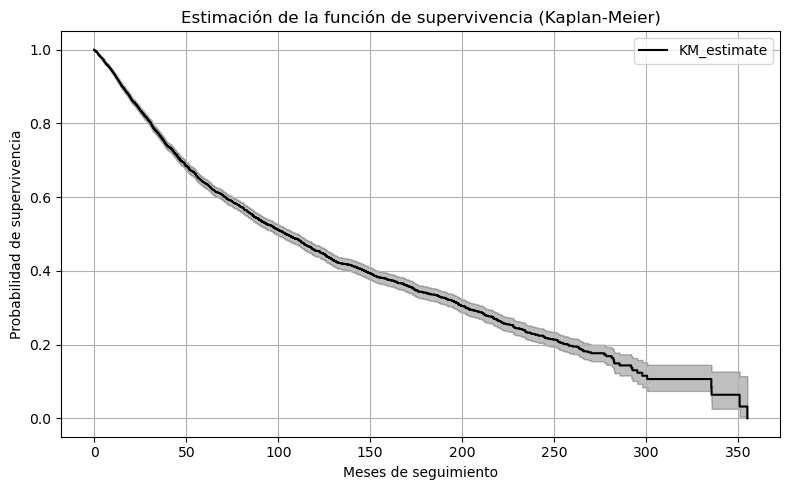

In [28]:
# Variables necesarias: duración (tiempo de seguimiento) y evento (si ha fallecido o no)
T = df['survival_months']           # tiempo de supervivencia
E = df['survival_status']           # evento: 1 = fallecido, 0 = censurado

# Crear y ajustar el modelo de Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Visualización de la curva
plt.figure(figsize=(8, 5))
kmf.plot(ci_show=True, color='black')
plt.title('Estimación de la función de supervivencia (Kaplan-Meier)', fontsize=12)
plt.xlabel('Meses de seguimiento')
plt.ylabel('Probabilidad de supervivencia')
plt.grid(True)
plt.tight_layout()
plt.savefig('grafico_resultado.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Función para graficar curvas Kaplan-Meier por subgrupo
def plot_km_by_group(df, group_col, title, save_path=None):
    # Filtrar valores no nulos
    df_clean = df[[group_col, 'survival_months', 'survival_status']].dropna()

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    for group in df_clean[group_col].unique():
        ix = df_clean[group_col] == group
        kmf.fit(df_clean.loc[ix, 'survival_months'], df_clean.loc[ix, 'survival_status'], label=str(group))
        kmf.plot(ci_show=False)

    plt.title(f'Curvas de supervivencia por {group_col}', fontsize=13)
    plt.xlabel('Meses de supervivencia')
    plt.ylabel('Probabilidad de supervivencia')
    plt.grid(True)
    plt.tight_layout()
    # Guardar imagen
    if save_path is None:
        # Sanitizar título para usar como nombre de archivo
        safe_title = (
            title.lower()
                 .replace(" ", "_")
                 .replace(":", "")
                 .replace("á", "a").replace("é", "e").replace("í", "i")
                 .replace("ó", "o").replace("ú", "u").replace("ñ", "n")
        )
        save_path = os.path.join(os.getcwd(), f"{safe_title}.png")

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Gráfico guardado en: {save_path}")

    plt.show()

Gráfico guardado en: C:\Users\USUARI\Desktop\UOC\TFM\genero.png


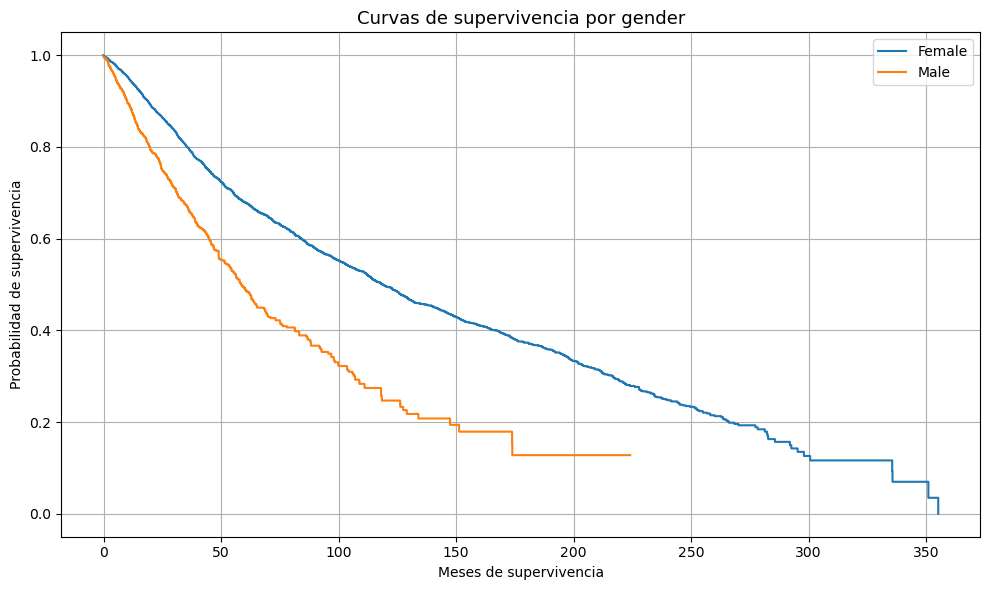

Gráfico guardado en: C:\Users\USUARI\Desktop\UOC\TFM\raza.png


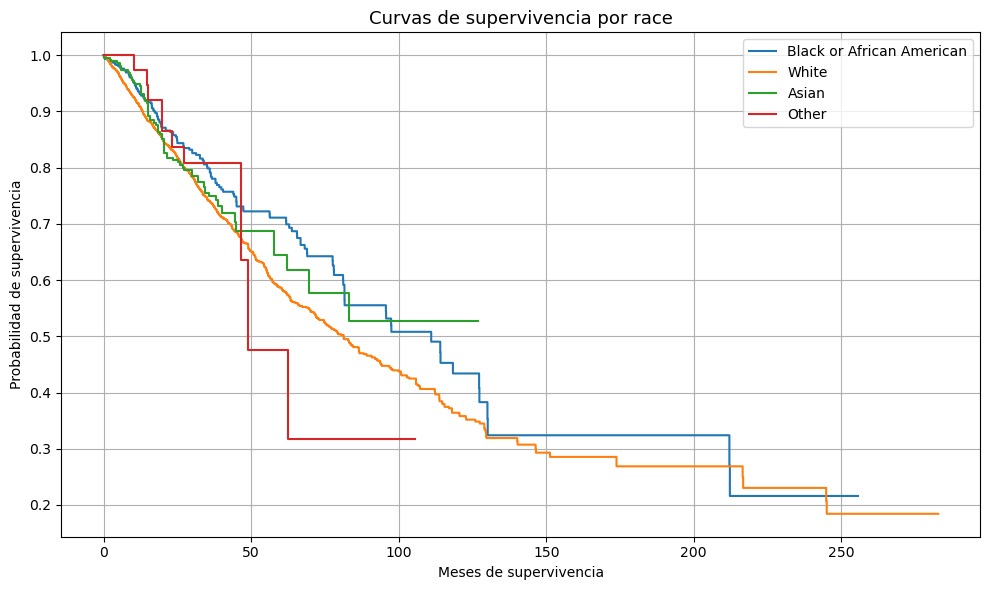

Gráfico guardado en: C:\Users\USUARI\Desktop\UOC\TFM\etnia.png


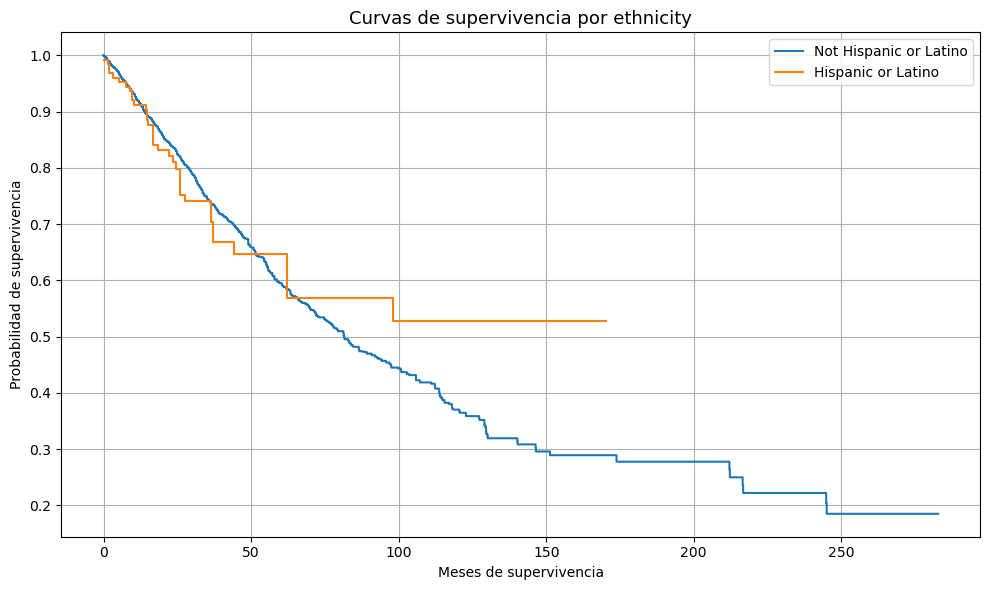

Gráfico guardado en: C:\Users\USUARI\Desktop\UOC\TFM\tipo_de_cancer.png


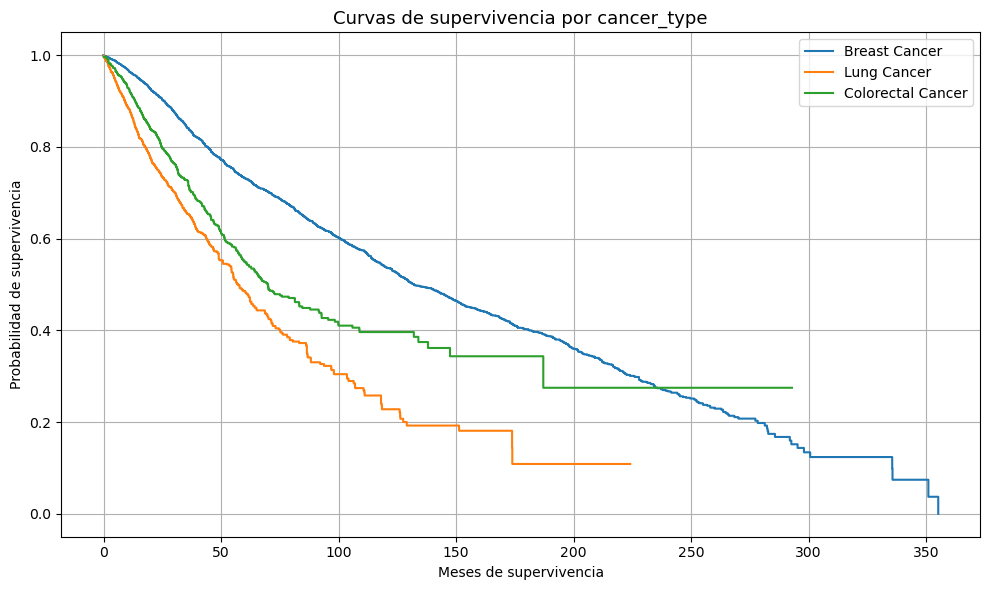

In [30]:
# Por género
plot_km_by_group(df, 'gender', 'Género')

# Por raza
plot_km_by_group(df, 'race', 'Raza')

# Por etnia
plot_km_by_group(df, 'ethnicity', 'Etnia')

# Por tipo de cáncer
plot_km_by_group(df, 'cancer_type', 'Tipo de cáncer')

In [31]:
# Crear grupos de 10 años para la edad
df['age_group'] = pd.cut(df['age_at_diagnosis'], bins=range(20, 101, 10), right=False)

Gráfico guardado en: C:\Users\USUARI\Desktop\UOC\TFM\grupos_de_edad_al_diagnostico_(cada_10_anos).png


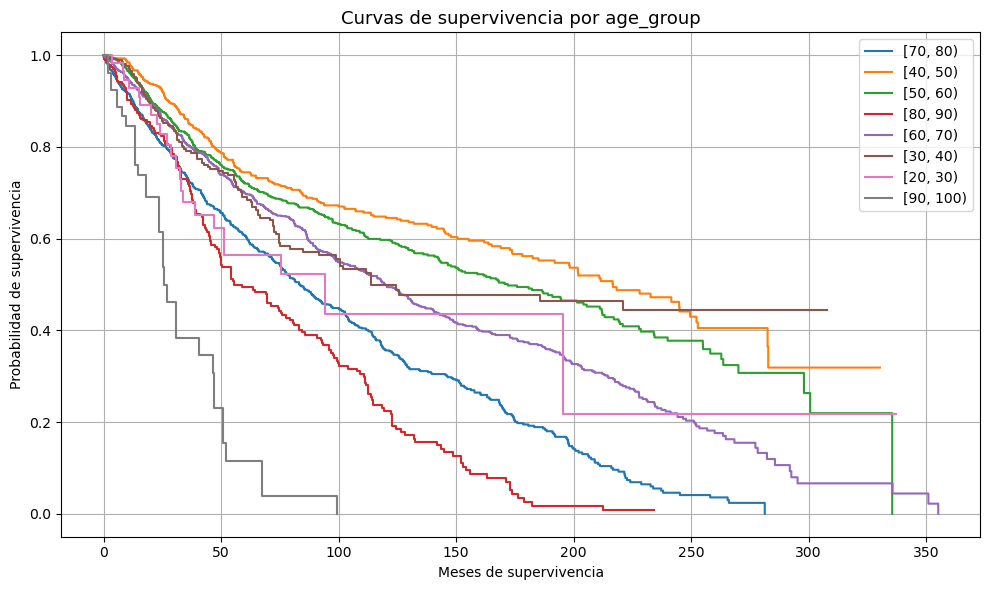

In [32]:
# Curvas para edad agrupada
plot_km_by_group(df, 'age_group', 'Grupos de edad al diagnóstico (cada 10 años)')

In [36]:
# Inicializamos y ajustamos el modelo
kmf = KaplanMeierFitter()
kmf.fit(df['survival_months'], df['survival_status'])

# Tiempos deseados en meses
time_points = [12, 36, 60]

# Estimaciones de supervivencia
surv_probs = kmf.predict(time_points)

# Intervalos de confianza por interpolación
ci_lower = kmf.confidence_interval_['KM_estimate_lower_0.95'].reindex(kmf.survival_function_.index.union(time_points)).interpolate().loc[time_points]
ci_upper = kmf.confidence_interval_['KM_estimate_upper_0.95'].reindex(kmf.survival_function_.index.union(time_points)).interpolate().loc[time_points]

# Construimos la tabla
table = pd.DataFrame({
    'Tiempo (meses)': time_points,
    'Supervivencia estimada': surv_probs.values,
    'IC 95% inferior': ci_lower.values,
    'IC 95% superior': ci_upper.values
}).round(3)

print(table)

   Tiempo (meses)  Supervivencia estimada  IC 95% inferior  IC 95% superior
0              12                   0.924            0.918            0.930
1              36                   0.765            0.755            0.774
2              60                   0.638            0.626            0.650


In [33]:
def logrank_tests_by_group(df, group_col):
    df_clean = df[[group_col, 'survival_months', 'survival_status']].dropna()
    unique_groups = df_clean[group_col].unique()

    print(f'\nResultados del test de Log-Rank para: {group_col.upper()}')

    for group1, group2 in combinations(unique_groups, 2):
        data1 = df_clean[df_clean[group_col] == group1]
        data2 = df_clean[df_clean[group_col] == group2]

        if len(data1) < 5 or len(data2) < 5:
            continue  # Omitimos comparaciones con muy pocos datos para evitar errores

        result = logrank_test(
            data1['survival_months'], data2['survival_months'],
            event_observed_A=data1['survival_status'],
            event_observed_B=data2['survival_status']
        )
        print(f'\n{group1} vs {group2}')
        result.print_summary()

In [34]:
logrank_tests_by_group(df, 'gender')
logrank_tests_by_group(df, 'race')
logrank_tests_by_group(df, 'ethnicity')
logrank_tests_by_group(df, 'cancer_type')


Resultados del test de Log-Rank para: GENDER

Female vs Male


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         250.33 <0.005    184.89


Resultados del test de Log-Rank para: RACE

Black or African American vs White


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.98 <0.005      8.52


Black or African American vs Asian


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.70 0.40      1.31


Black or African American vs Other


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.29 0.26      1.97


White vs Asian


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.38 0.12      3.02


White vs Other


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.03 0.86      0.21


Asian vs Other


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.27 0.60      0.73


Resultados del test de Log-Rank para: ETHNICITY

Not Hispanic or Latino vs Hispanic or Latino


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.22 0.64      0.64


Resultados del test de Log-Rank para: CANCER_TYPE

Breast Cancer vs Lung Cancer


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         446.45 <0.005    326.77


Breast Cancer vs Colorectal Cancer


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         157.29 <0.005    117.44


Lung Cancer vs Colorectal Cancer


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          33.71 <0.005     27.22